In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [16]:
from lsst.daf.persistence import Butler, NoResults
import lsst.geom as geom

Quick look at failures in DiaSource centroiding during ap_verify runs of the HiTS-2015 dataset. These were found on ticket DM-28961 and possibly relate to DM-26032. In a quick summary: sources were found that have NaieveCentroids off of the difference image. Their peak centroids are properly measured it apears though. It is unclear why the CentroidChecker, which I have confirmed to be set for doFootprintCheck=True, does not catch these problems and reset the centroid to the peak value.

The commonalities between sources appear to be that they are all edge sources (they are flagged as such) and large fraction of cutouts have a clearly indetifiable "hard edge" across the image cutout. I don't see anything obvious in DipoleFitTask or its plugins/algorithms that could cause this problem but I might be overlooking something. For general information: the centroid used in AP processing is the NaiveDipoleCentroid which defaults to SDSS which defaults to NaiveCentroid which should default to the PeakCentroid when failures occur. It appears this is happening as expected up to NaiveCentroid failing to default to PeakCentroid. For reference the PeakCentroid vs NaiveCentroid can be off from each other by up to ~600 pixels as shown by these data.

Below is a summary of some of this investiation.

In [6]:
# Visits with at least one failed DiaSource centroid off the difference image.
visitCcd = [{'filter': 'g', 'visit': 411671, 'ccdnum': 27},
            {'filter': 'g', 'visit': 413649, 'ccdnum': 43},
            {'filter': 'g', 'visit': 411657, 'ccdnum': 31},
            {'filter': 'g', 'visit': 411369, 'ccdnum': 56},
            {'filter': 'g', 'visit': 412604, 'ccdnum': 9},
            {'filter': 'g', 'visit': 411824, 'ccdnum': 18},
            {'filter': 'g', 'visit': 411808, 'ccdnum': 3},
            {'filter': 'g', 'visit': 421590, 'ccdnum': 16},
            {'filter': 'g', 'visit': 412668, 'ccdnum': 7},
            {'filter': 'g', 'visit': 411721, 'ccdnum': 1},
            {'filter': 'g', 'visit': 410915, 'ccdnum': 44},
            {'filter': 'g', 'visit': 410915, 'ccdnum': 53},
            {'filter': 'g', 'visit': 410985, 'ccdnum': 55},
            {'filter': 'g', 'visit': 413651, 'ccdnum': 7},
            {'filter': 'g', 'visit': 411472, 'ccdnum': 28},
            {'filter': 'g', 'visit': 413651, 'ccdnum': 55},
            {'filter': 'g', 'visit': 412074, 'ccdnum': 31},
            {'filter': 'g', 'visit': 411255, 'ccdnum': 31},
            {'filter': 'g', 'visit': 411758, 'ccdnum': 4}]

In [27]:
# Connect to a repo with the HiTS-2015 data.
b = Butler("/project/morriscb/src/ap_verify_hits2015/DM-28961/output")

In [108]:
# Load the data and retieve all DiaSources with centroid outside of the difference image.
# bounding box. Print the visit
failedDiaSources = []
peakCutouts = []
for dataId in visitCcd:
    try:
        diffIm = b.get("deepDiff_differenceExp",
                       visit=dataId["visit"],
                       ccdnum=dataId["ccdnum"])
        diaSrc = b.get("deepDiff_diaSrc", visit=dataId["visit"], ccdnum=dataId["ccdnum"])
    except NoResults:
        continue
    wcs = diffIm.getWcs()
    bbox = geom.Box2D(diffIm.getBBox())
    for src in diaSrc:
        if not bbox.contains(src.getCentroid()):
            footPrintBBox = src.getFootprint().getBBox()
            footPrintExtent = src.getFootprint().getBBox().getDimensions()
            sphPoint = wcs.pixelToSky(src.getFootprint().getCentroid())
            failedDiaSources.append([src,
                                     boxSize / 2 - 1,
                                     boxSize / 2 - 1])
            peakCutouts.append(diffIm.getCutout(sphPoint, footPrintExtent))
            print({"visit": dataId["visit"],
                   "ccdnum": dataId["ccdnum"],
                   "Source Centroid": src.getCentroid(),
                   "Peak Centroid": geom.Point2D(src["base_PeakCentroid_x"], src["base_PeakCentroid_y"]),
                   "NaiveCentroid_GeneralFlag": src["base_NaiveCentroid_flag"],
                   "NaiveCentroid_EdgeFlag": src["base_NaiveCentroid_flag_edge"]})

{'visit': 411671, 'ccdnum': 27, 'Source Centroid': Point2D(994.6505737, -8.02089119), 'Peak Centroid': Point2D(975, 16), 'NaiveCentroid_GeneralFlag': True, 'NaiveCentroid_EdgeFlag': True}
{'visit': 413649, 'ccdnum': 43, 'Source Centroid': Point2D(703.0117188, 4096.378418), 'Peak Centroid': Point2D(698, 4077), 'NaiveCentroid_GeneralFlag': True, 'NaiveCentroid_EdgeFlag': True}
{'visit': 411369, 'ccdnum': 56, 'Source Centroid': Point2D(1072.251831, 4097.976074), 'Peak Centroid': Point2D(1079, 4080), 'NaiveCentroid_GeneralFlag': True, 'NaiveCentroid_EdgeFlag': True}
{'visit': 412604, 'ccdnum': 9, 'Source Centroid': Point2D(2430.334961, -573.5247803), 'Peak Centroid': Point2D(1778, 17), 'NaiveCentroid_GeneralFlag': True, 'NaiveCentroid_EdgeFlag': True}
{'visit': 411824, 'ccdnum': 18, 'Source Centroid': Point2D(174.0563266, 4104.763518), 'Peak Centroid': Point2D(170, 4078), 'NaiveCentroid_GeneralFlag': True, 'NaiveCentroid_EdgeFlag': True}
{'visit': 421590, 'ccdnum': 16, 'Source Centroid': P

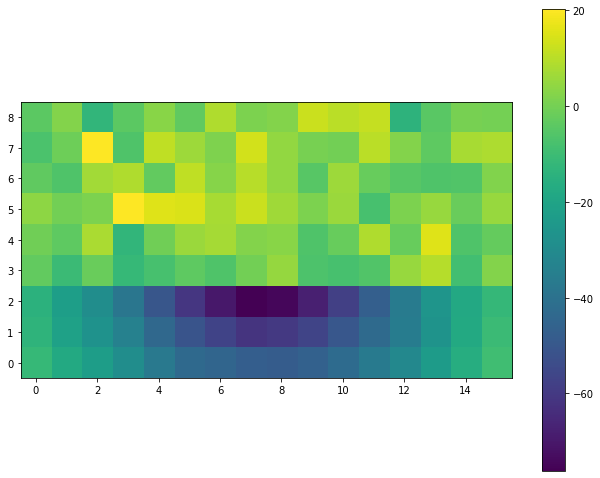

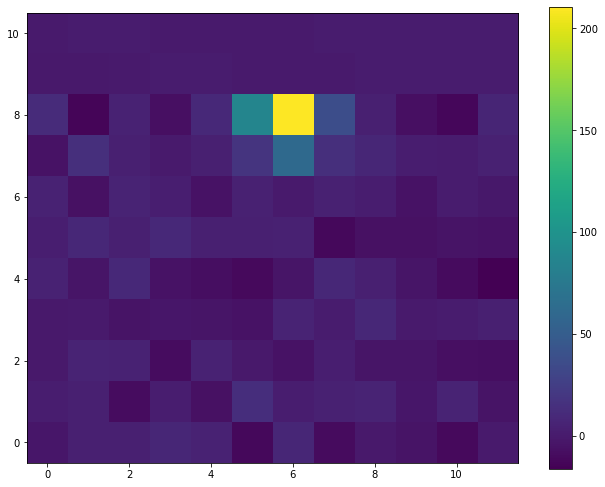

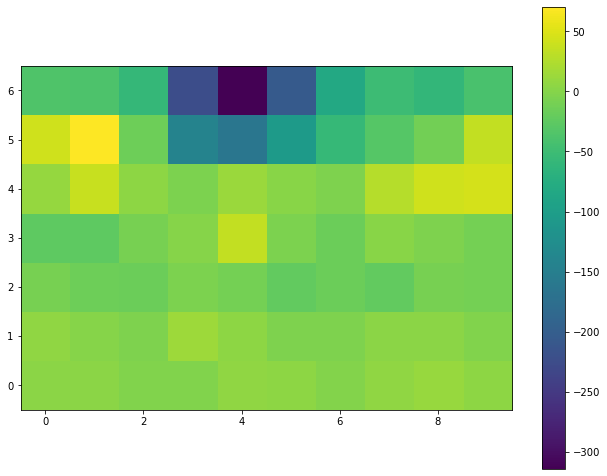

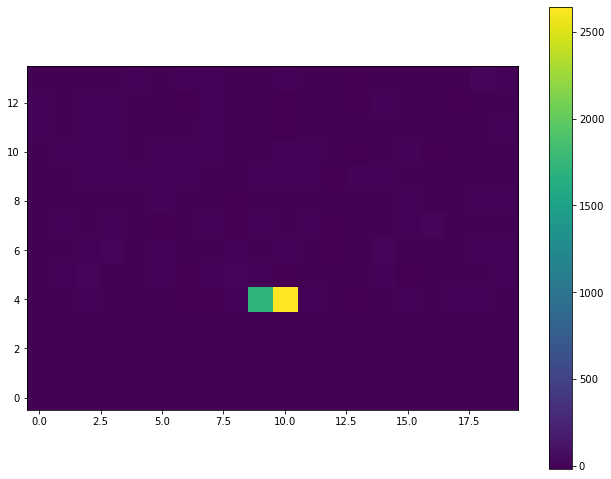

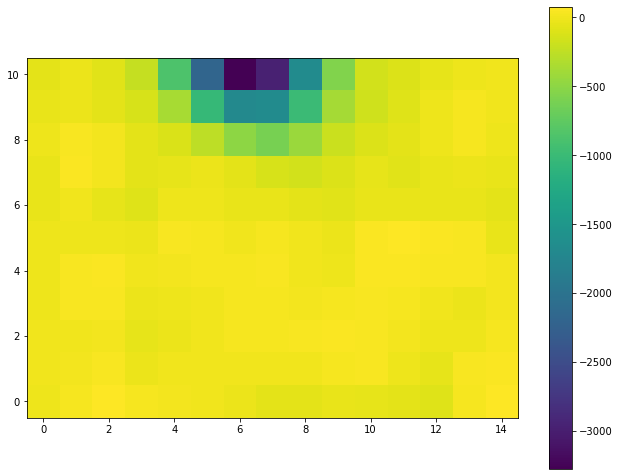

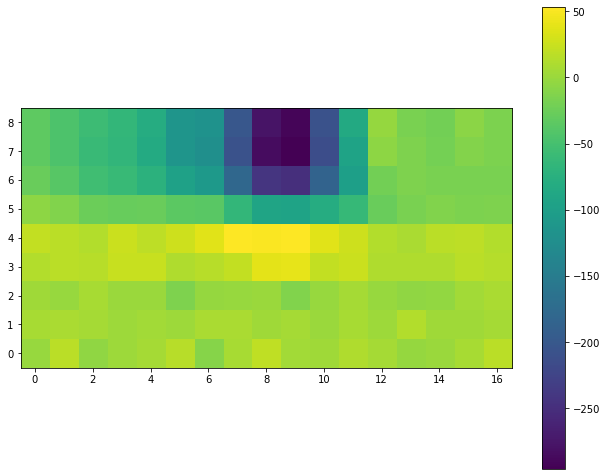

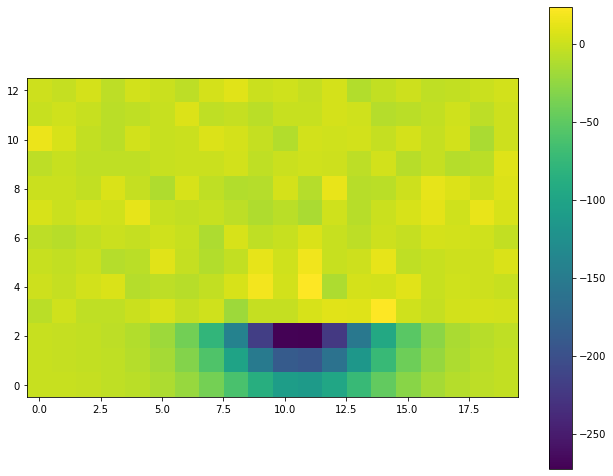

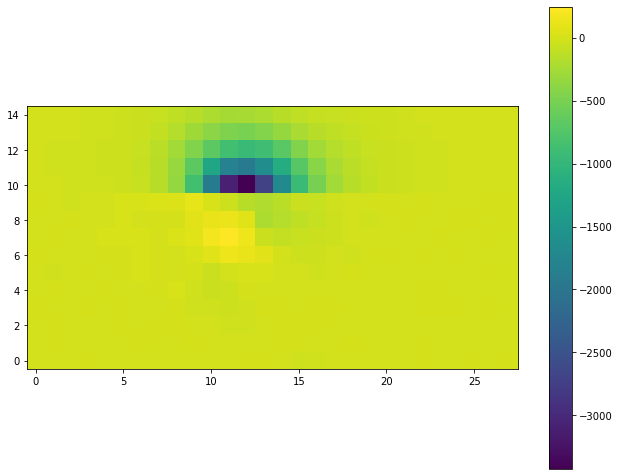

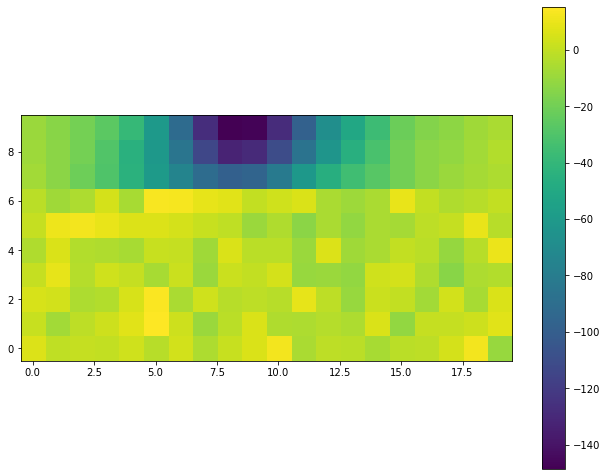

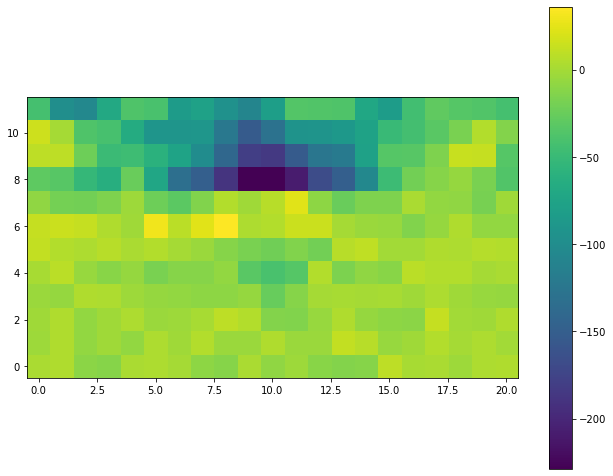

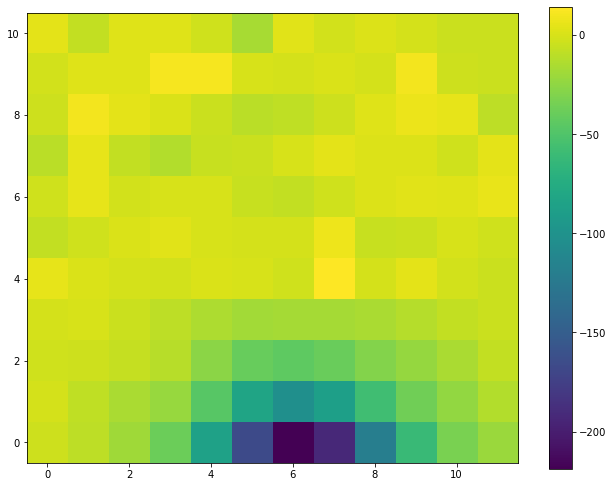

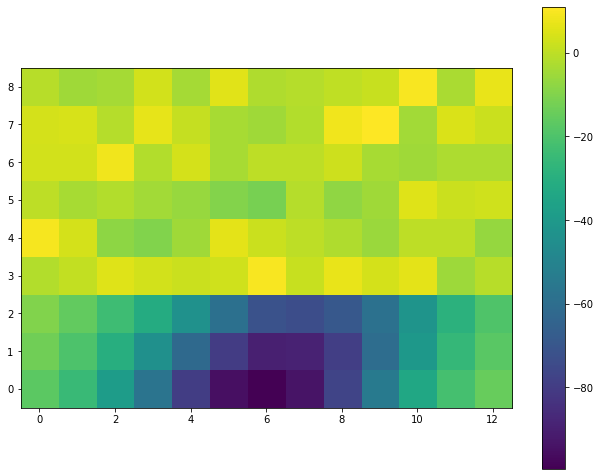

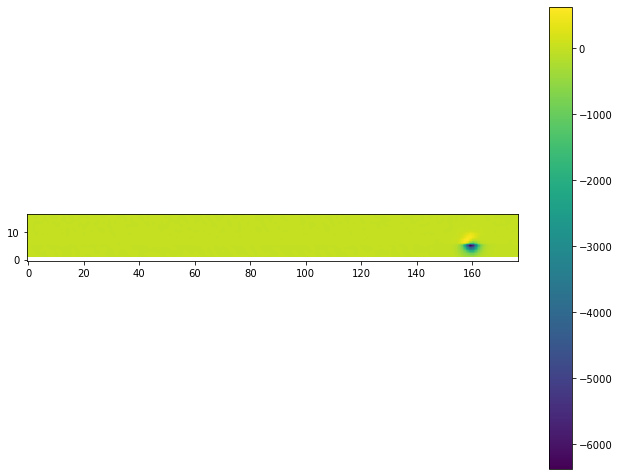

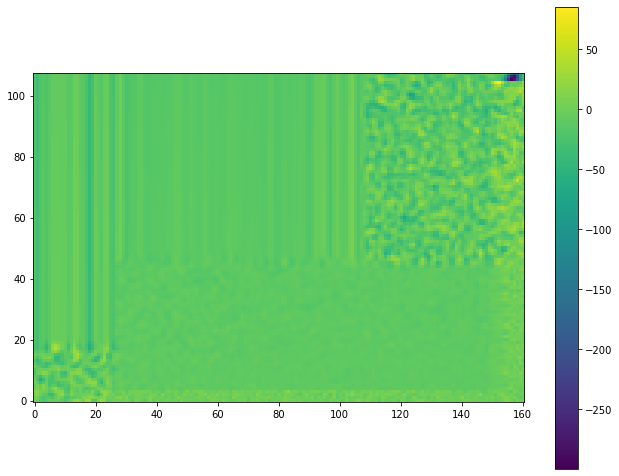

In [99]:
# Display "failedSource" footprint cutout centered at footprint center.
for cutout, src in zip(peakCutouts, failedDiaSources):
    figure(figsize=(11, 8.5))
    imshow(cutout.image.array, origin="lower")
    colorbar()

In [103]:
# Show all peaks in footprint.
for src in failedDiaSources:
    print(src[0].getFootprint().getPeaks())

  id   f_x  f_y  i_x i_y peakValue 
       pix  pix  pix pix     ct    
----- ----- ---- --- --- ----------
90761 975.0 16.0 975  16 -10.674724
  id    f_x   f_y   i_x i_y  peakValue
        pix   pix   pix pix      ct   
------ ----- ------ --- ---- ---------
139731 698.0 4077.0 698 4077  6.374448
  id   f_x    f_y   i_x  i_y  peakValue 
       pix    pix   pix  pix      ct    
----- ------ ------ ---- ---- ----------
65235 1079.0 4080.0 1079 4080 -17.504627
  id    f_x   f_y  i_x  i_y peakValue
        pix   pix  pix  pix     ct   
------ ------ ---- ---- --- ---------
330031 1778.0 17.0 1778  17 102.44529
  id   f_x   f_y   i_x i_y  peakValue 
       pix   pix   pix pix      ct    
----- ----- ------ --- ---- ----------
69092 170.0 4078.0 170 4078   19.76257
69258 167.0 4080.0 167 4080 -40.678715
  id   f_x   f_y   i_x i_y  peakValue 
       pix   pix   pix pix      ct    
----- ----- ------ --- ---- ----------
86250 968.0 4080.0 968 4080 -31.971539
  id    f_x  f_y  i_x i_y peakVal